In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.python.data import Dataset
from sklearn import metrics
import math


In [33]:
california_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [7]:
california_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
#shuffling data
california_data = california_data.reindex(np.random.permutation(california_data.index))
california_data['median_house_value'] /= 1000

In [9]:
#Define input function
def my_input(features, target, batch_size = 1, shuffle = True, num_epochs = None):
    #convert pandas feature data into dict of numpy arrays
    features = {key:np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features,target))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size = 10000)
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels

    

In [22]:
#Wrap everything inside a function
def my_train(steps, batch_size, learning_rate, input_feature = 'total_rooms'):
    #define feature and configure feature_columns
    my_feature = input_feature
    my_feature_data = california_data[[my_feature]]
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    #define targets
    my_label = 'median_house_value'
    targets = california_data[my_label]
    
    #configure LinearRegressor
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5)
    linear_regressor = tf.estimator.LinearRegressor(optimizer=my_optimizer, feature_columns=feature_columns)
    
    #input functions
    training_input_fn = lambda: my_input(my_feature_data, targets, shuffle = True, num_epochs = None)
    prediction_input_fn = lambda: my_input(my_feature_data, targets, shuffle = False, num_epochs = 1)
    
    periods = 10
    steps_per_period = steps / periods
    RMSE = []
    #do training inside loop
    for period in range(0,periods):
        print("training period: ", period)
        linear_regressor.train(input_fn=training_input_fn, steps = steps_per_period)
        prediction = linear_regressor.predict(input_fn=prediction_input_fn)
        prediction = np.array([item['predictions'][0] for item in prediction])
        rmse = math.sqrt(metrics.mean_squared_error(prediction, targets))
        RMSE.append(rmse)
        print("rmse: ", rmse)
    print("Model training finished")
    calibrated_data = pd.DataFrame()
    calibrated_data['targets'] = pd.Series(targets)
    calibrated_data['prediction'] = pd.Series(prediction)
    print("Final RMSE: ", RMSE)
    return calibrated_data
    

In [23]:
calibrated_data = my_train(input_feature="housing_median_age",steps = 100, batch_size = 10, learning_rate = 0.001)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_service': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_session_config': None, '_master': '', '_model_dir': 'C:\\Users\\A7567~1.EZH\\AppData\\Local\\Temp\\tmpsmcy3d1w', '_is_chief': True, '_evaluation_master': '', '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022F0D99AC18>}
training period:  0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\A7567~1.EZ

INFO:tensorflow:Saving checkpoints for 80 into C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpsmcy3d1w\model.ckpt.
INFO:tensorflow:Loss for final step: 40701.03.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpsmcy3d1w\model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
rmse:  227.40986687212805
training period:  8
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpsmcy3d1w\model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 81 into C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpsmcy3d1w\model.ckpt.
INFO:tensorflow:loss = 22172.072, step 

In [24]:
calibrated_data.describe()

,targets,prediction
count,17000.000000,17000.000000
mean,207.300912,14.293105
std,115.983764,6.282568
min,14.999000,0.522321
25%,119.400000,9.007599
50%,180.400000,14.498073
75%,265.000000,18.491146
max,500.001000,25.978155


In [93]:
california_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
15163,-122.26,37.51,46.0,672.0,149.0,351.0,136.0,5.3264,258.1,1.914530
12625,-121.72,37.98,5.0,7105.0,1143.0,3523.0,1088.0,5.0468,168.8,2.016747
5256,-118.14,34.08,30.0,1433.0,397.0,1110.0,346.0,2.3464,191.7,1.290991
16929,-124.11,40.93,25.0,2392.0,474.0,1298.0,461.0,3.5076,73.6,1.842835
14835,-122.21,37.47,43.0,733.0,162.0,497.0,175.0,3.2708,255.3,1.474849


In [25]:
california_data['rooms_per_person'] = california_data['total_rooms']/california_data['population']

In [32]:
my_train(input_feature = 'rooms_per_person',steps = 500, learning_rate = 0.005, batch_size = 10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_service': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_session_config': None, '_master': '', '_model_dir': 'C:\\Users\\A7567~1.EZH\\AppData\\Local\\Temp\\tmpge93z_ia', '_is_chief': True, '_evaluation_master': '', '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022F0C2CF208>}
training period:  0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\A7567~1.EZ

INFO:tensorflow:loss = 25323.7, step = 351
INFO:tensorflow:Saving checkpoints for 400 into C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpge93z_ia\model.ckpt.
INFO:tensorflow:Loss for final step: 74937.875.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpge93z_ia\model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
rmse:  217.81629485569977
training period:  8
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpge93z_ia\model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 401 into C:\Users\A7567~1.EZH\AppData\Local\Temp\tmpge93z_ia\mod

,targets,prediction
2628,279.600,15.586976
2308,95.200,29.841404
6062,110.400,32.395218
4541,161.200,15.854457
1061,263.600,23.557236
10637,60.900,28.259222
6085,396.400,25.186255
3779,153.400,14.515299
10110,206.300,23.116224
10994,166.100,27.548040


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


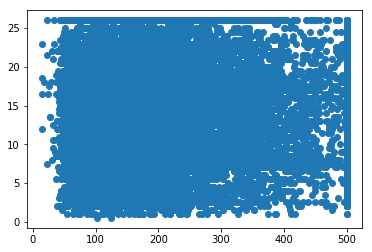

In [27]:
#visualising model's performance in scatter plot
!pip install matplotlib
import matplotlib.pyplot as plt
plt.scatter(calibrated_data['targets'],calibrated_data['prediction'])
plt.show()

In [28]:
#Handling outliers
clipped_feature = california_data['rooms_per_person'].apply(lambda x: max(x,0))
california_data['rooms_per_person'] = clipped_feature

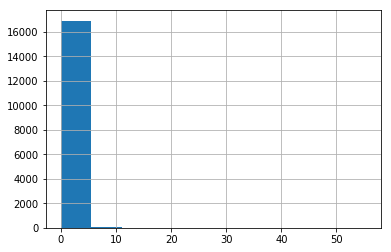

In [31]:
california_data['rooms_per_person'].hist()